<a href="https://colab.research.google.com/github/pyqt555/cudaFieldLines/blob/master/interface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
#@title Setup
import numpy as np
import numba
from numba import float64
import math
import time
import cv2 as cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb as rgb
import os
try:
    from google.colab.patches import cv2_imshow
except:
    print("Not running on Colab, replace cv2_imshow with cv2.imshow()")
from joblib import Parallel, delayed
from multiprocessing.dummy import Pool as ThreadPool
import itertools

X=0
Y=1
C=2
TIMESCALE=10.2 #@param {type:"slider",min:0.01,max:100,step:0.01}
UsE0 =False #@param {type:"boolean"}
if UsE0:
  E0=8.8541878128*(10**(-12))
else:
  E0=1

@numba.guvectorize([(float64[:],float64[:],float64[:])], '(n),(n)->(n)',target="parallel")
def compute_force_guv(c1,c2,res):
    c_dir=c1[C]*c2[C]
    dist=((c1[X]-c2[X])**2+(c1[Y]-c2[Y])**2)**.5
    dir_vec=[c1[X]-c2[X],c1[Y]-c2[Y]]
    dir_len=dist
    norm_vec=[dir_vec[X]/dir_len,dir_vec[Y]/dir_len]
    return_const=(1/(4*math.pi*(dist**2)*E0))*TIMESCALE*c_dir*(-1)#-1 for correct direction
    res[:]=[norm_vec[X]*return_const,norm_vec[Y]*return_const,0]


@numba.jit
def compute_vectors_guv_fixed_output(non_statics,statics):
    f=compute_force_guv(non_statics,statics,np.zeros((statics.shape[0],3)))[:,:2]
    return np.array([np.sum(f[:,0]),np.sum(f[:,1])])
#@numba.jit
def compute_line(testcharge,line_length,statics):
  #print("new Charge")
  positions=[]
  for i in range(int(line_length)):
        #if i%100==0:
        #  print(i)
        testcharge_dir=compute_vectors_guv_fixed_output([testcharge],statics)
        
        testcharge=[testcharge[X]+testcharge_dir[X],testcharge[Y]+testcharge_dir[Y],testcharge[C]]
        
        if (testcharge_dir[X]**2+testcharge_dir[Y]**2) >(1*TIMESCALE)**2:
          #print(i)
          #print(np.sum(testcharge_dir**2))
          break
   
        positions.append(testcharge)
  #print("computed")
  return positions

def compute_lines(statics,nonstatics,line_length=1000):
    nonstatics=nonstatics.copy()
    positions=[]
    pool = ThreadPool(int((nonstatics.shape[0]/2)+0.999))
    print(nonstatics.shape[0])
    results = pool.starmap(compute_line, zip(nonstatics,itertools.repeat(line_length),itertools.repeat(statics)))
    pool.close()
    pool.join()
    #results=compute_line(nonstatics[0],line_length,statics)
    return np.array(results)

def extract_charges(img,val_img=None):
  img=cv2.cvtColor(img.copy(),cv2.COLOR_BGR2HSV)
  
  if type(val_img)!=type(None):
    valarray=cv2.cv2Color(val_img.copy(),cv2.COLOR_BGR2GRAY)/255
  else:
    valarray=np.ones(img[:,:,0].shape)
   
  bluemask=cv2.inRange(img, (80,125,125), (130,255,255))
  redmaskimg=img
  redmaskimg[:,:,0]+=75
  redmaskimg[:,:,0]=redmaskimg[:,:,0]%180
  redmask=cv2.inRange(redmaskimg,(65,125,125),(85,255,255))
  #cv2_imshow(redmask)
  #cv2_imshow(bluemask)
  #pos_charge_img=redmask*valarray
  #neg_charge_img=redmask*valarray*(-1)
  charges=[]
  neg_c=np.array(np.where(bluemask!=0))
  for i in range(neg_c.shape[1]):
    coords=neg_c[:,i]
    charges.append([coords[1],bluemask.shape[0]-coords[0]-1,valarray[coords[0],coords[1]]*-1])
  pos_c=np.array(np.where(redmask!=0))
  for i in range(neg_c.shape[1]):
    coords=pos_c[:,i]
    charges.append([coords[1],bluemask.shape[0]-coords[0]-1,valarray[coords[0],coords[1]]])
  return np.array(charges)

def distribute_line_charges(img,res_x,res_y=None):
  if type(res_y)==type(None):
    res_y=res_x
  
  x_coords=((np.arange(res_x)+.5)/res_x)*img.shape[1]
  y_coords=((np.arange(res_y)+.5)/res_y)*img.shape[0]
  lines=np.array(np.meshgrid(x_coords,y_coords,(-1,1))).T.reshape(-1,3)
  return lines

In [16]:
#@title Display Files
print(os.listdir())

['.config', 'test.png', 'sample_data']


In [17]:
#@title Load Image
Filename = "test.png" #@param {type:"string"}
image=cv2.imread(Filename)
#@markdown 
Use_Value_Image = False #@param {type:"boolean"}
#@markdown Whether every charge has the same value or one specified by an additional image(grayscale, white is 255/255, black is 0/255)
if Use_Value_Image:
  Val_Filename = "val.png" #@param {type:"string"}
  #@markdown Ignore if above box is unchecked, else id filename for said image
  val_image=cv2.imread(Val_Filename)
else:
  pass

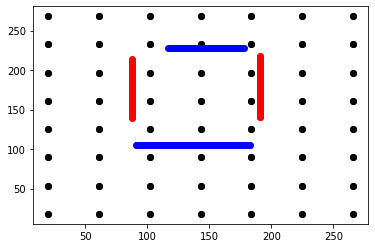

In [63]:
#@title Load Charges from Image
#@markdown Scaling input image down for speed
Scale = 28 #@param {type:"slider", min:0, max:200, step:1}

width = int(image.shape[1] * Scale / 100)
height = int(image.shape[0] * Scale / 100)
dim = (width, height)
img = cv2.resize(image.copy(), dim, interpolation = cv2.INTER_AREA)
if Use_Value_Image:
  val_image=cv2.resize(val_image.copy(), dim, interpolation = cv2.INTER_AREA)
else:
  val_image=None
stationary_charges=extract_charges(img.copy(),val_image)
#@markdown Distributing Lines
lines_x = 7 #@param {type:"integer"}
lines_y = 8 #@param {type:"integer"}
line_charges=distribute_line_charges(img.copy(),lines_x,lines_y)
for line_charge in line_charges:
  
  plt.plot(line_charge[0], line_charge[1],"o" ,color=rgb((1,1.,0.)))
for stat_charge in stationary_charges:
  if stat_charge[2]>0:
    h=1
  else:
    h=2/3
  plt.plot(stat_charge[0], stat_charge[1],"o" ,color=rgb((h,1.,1.)))
plt.show()

In [60]:
#@title Compute Lines
Line_length = 2332 #@param {type:"slider", min:10, max:10000, step:1}
lines=np.array(compute_lines(stationary_charges,line_charges,Line_length))

112


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


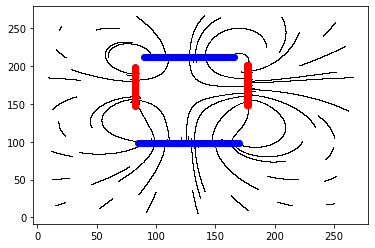

In [61]:
#@title Display Lines 
displayType = "pixel" #@param ["pixel", "line", "circle"]
Circle_size = 0.062 #@param {type:"slider", min:0, max:2, step:0.001}
Line_width = 0.08 #@param {type:"slider", min:0, max:2, step:0.001}
if displayType=="pixel":
  for line in lines:
    if len(line)>0:
      nl=[]
      for el in line:
        if not (el[0]>img.shape[0]or el[1]>img.shape[1]or el[0]<0 or el[1]<0):
          nl.append([el[0],el[1]])
      nl=np.array(nl)
      #print(nl)
     
      plt.plot(nl[:,0], nl[:,1],",",color="black")
elif displayType=="circle":
  for line in lines:
    if len(line)>0:
      nl=[]
      for el in line:
        if not (el[0]>img.shape[0]or el[1]>img.shape[1]or el[0]<0 or el[1]<0):
          nl.append([el[0],el[1]])
      nl=np.array(nl)
      #print(nl)
     
      plt.plot(nl[:,0], nl[:,1],"o",color="black",markersize=Circle_size)
elif displayType=="line":
  for line in lines:
    if len(line)>0:
      nl=[]
      for el in line:
        if not (el[0]>img.shape[0]or el[1]>img.shape[1]or el[0]<0 or el[1]<0):
          nl.append([el[0],el[1]])
      nl=np.array(nl)
      #print(nl)
     
      plt.plot(nl[:,0], nl[:,1],color="black",linestyle='-', linewidth=Line_width)
for stat_charge in stationary_charges:
  if stat_charge[2]>0:
    h=1
  else:
    h=2/3
  plt.plot(stat_charge[0], stat_charge[1],"o" ,color=rgb((h,1.,1.)))
plt.show()
      



